In [ ]:
import keras
from keras.datasets import mnist
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Flatten
from keras import optimizers
from tensorflow.keras.applications import Xception

from keras.models import Sequential
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, UpSampling2D, LeakyReLU, MaxPooling2D, BatchNormalization
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow import optimizers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Flatten
from keras import optimizers
from keras.models import Sequential
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, UpSampling2D, LeakyReLU, MaxPooling2D, BatchNormalization
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow import optimizers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator\

from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt


In [ ]:
import os
import shutil
import numpy as np


# Define paths
source_dir = '/content/drive/MyDrive/covid projrct dataset 2'
train_dir = '/content/drive/MyDrive/train test val 2/train'
val_dir = '/content/drive/MyDrive/train test val 2/val'
test_dir = '/content/drive/MyDrive/train test val 2/test'

In [ ]:



# Calculate class weights
def count_images_in_classes(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        print(class_name)
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

train_class_counts = count_images_in_classes(train_dir)
num_classes = len(train_class_counts)
total_samples = sum(train_class_counts.values())

class_weights = {i: total_samples / (num_classes * count) for i, count in enumerate(train_class_counts.values())}
print("Class weights:", class_weights)

COVID
NORMAL
pneumonia
Class weights: {0: 1.369757174392936, 1: 0.8820184790334044, 2: 0.8801418439716312}


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator for training data with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# ImageDataGenerator for validation and test data without data augmentation
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 2482 images belonging to 3 classes.
Found 531 images belonging to 3 classes.
Found 535 images belonging to 3 classes.


In [ ]:
num_batches = len(train_generator)
total_new_data = num_batches * train_generator.batch_size

print("Total new data generated:", total_new_data)
print(num_batches)

Total new data generated: 2496
78


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16

# Load pre-trained VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Define the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, kernel_regularizer=l2(0.01)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),  # Add Batch Normalization
    Dropout(0.5),  # Add dropout for regularization
    Dense(128, kernel_regularizer=l2(0.01)),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),
    Dense(3, activation='softmax')
])


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

In [ ]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
# Define callbacks
checkpoint = ModelCheckpoint("model_checkpoint.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min', min_lr=1e-6)

callbacks = [checkpoint, lr_scheduler]

# Training configuration
epochs = 20
# Start training
start_time = datetime.now()

history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator,
                    callbacks=callbacks,class_weight=class_weights)

# Calculate training duration
training_duration = datetime.now() - start_time
print("Training duration:", training_duration)


Epoch 1/20
78/78 [==============================] - ETA: 0s - loss: 6.4668 - accuracy: 0.7768
Epoch 1: val_loss improved from inf to 5.69464, saving model to model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 658s 8s/step - loss: 6.4668 - accuracy: 0.7768 - val_loss: 5.6946 - val_accuracy: 0.8249 - lr: 1.0000e-04
Epoch 2/20
78/78 [==============================] - ETA: 0s - loss: 5.2883 - accuracy: 0.8469
Epoch 2: val_loss improved from 5.69464 to 5.03390, saving model to model_checkpoint.h5
78/78 [==============================] - 432s 6s/step - loss: 5.2883 - accuracy: 0.8469 - val_loss: 5.0339 - val_accuracy: 0.8249 - lr: 1.0000e-04
Epoch 3/20
78/78 [==============================] - ETA: 0s - loss: 4.7739 - accuracy: 0.8707
Epoch 3: val_loss improved from 5.03390 to 4.45931, saving model to model_checkpoint.h5
78/78 [==============================] - 434s 6s/step - loss: 4.7739 - accuracy: 0.8707 - val_loss: 4.4593 - val_accuracy: 0.9002 - lr: 1.0000e-04
Epoch 4/20
78/78 [==============================] - ETA: 0s - loss: 4.4164 - accuracy: 0.8707
Epoch 4: val_loss improved from 4.45931 to 4.13751, saving model to model_checkpoint.h5
78/78 [======

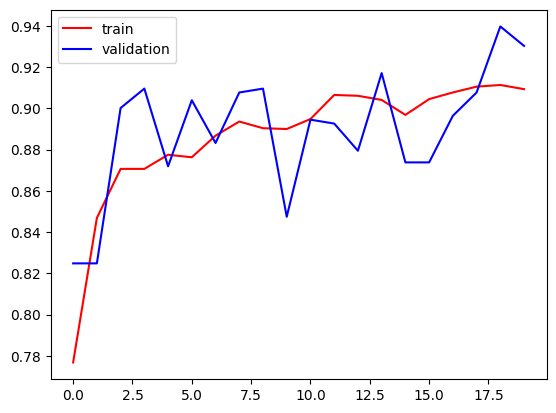

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

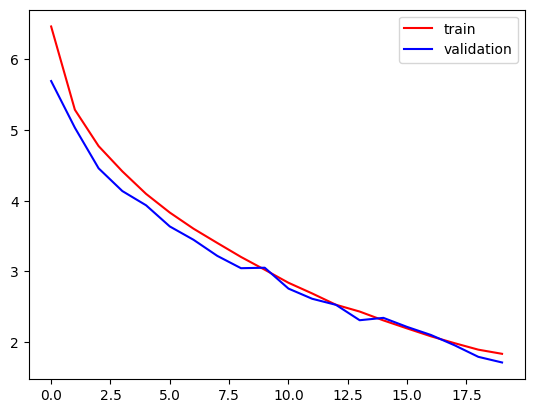

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

17/17 [==============================] - 132s 8s/step - loss: 1.7288 - accuracy: 0.9364
Test Loss: 1.728793978691101
Test Accuracy: 0.9364485740661621


In [ ]:
from sklearn.metrics import classification_report

# Assuming you have already trained your model and loaded test data

# Evaluate the model on the training set
train_loss, train_accuracy = model.evaluate(train_generator)

# Predict classes for training set
train_predictions = model.predict(train_generator)
train_predicted_classes = np.argmax(train_predictions, axis=1)

# Get true labels for training set
train_true_classes = train_generator.classes

# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Generate classification report for training set
train_report = classification_report(train_true_classes, train_predicted_classes, target_names=class_labels)

print("Training Classification Report:")
print(train_report)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

# Predict classes for validation set
test_predictions = model.predict(test_generator)
test_predicted_classes = np.argmax(test_predictions, axis=1)

# Get true labels for validation set
test_true_classes = test_generator.classes

# Generate classification report for validation set
test_report = classification_report(test_true_classes, test_predicted_classes, target_names=class_labels)

print("test Classification Report:")
print(test_report)


78/78 [==============================] - 354s 5s/step
Training Classification Report:
              precision    recall  f1-score   support

       COVID       0.24      0.26      0.25       604
      NORMAL       0.36      0.35      0.36       938
   pneumonia       0.38      0.37      0.37       940

    accuracy                           0.34      2482
   macro avg       0.33      0.33      0.33      2482
weighted avg       0.34      0.34      0.34      2482

17/17 [==============================] - 75s 4s/step
test Classification Report:
              precision    recall  f1-score   support

       COVID       0.25      0.25      0.25       131
      NORMAL       0.36      0.38      0.37       202
   pneumonia       0.37      0.35      0.36       202

    accuracy                           0.33       535
   macro avg       0.32      0.32      0.32       535
weighted avg       0.34      0.33      0.33       535

